## EDA
### Install packages

In [2]:
# Setup - Run only once per Kernel App
%conda install openjdk -y

# install PySpark
%pip install pyspark==3.3.0

# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.10.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.10.0



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - openjdk


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2023.08.22 |       h06a4308_0         123 KB
    certifi-2023.7.22          |  py310h06a4308_0         153 KB
    openjdk-11.0.13            |       h87a67e3_0       341.0 MB
    ------------------------------------------------------------
                                           Total:       341.3 MB

The following NEW packages will be INSTALLED:

  openjdk            pkgs/main/linux-64::openjdk-11.0.13-h87a67e3_0 



### Build Spark Session

In [3]:
# Import pyspark and build Spark session
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder.appName("PySparkApp")
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.2.2")
    .config(
        "fs.s3a.aws.credentials.provider",
        "com.amazonaws.auth.ContainerCredentialsProvider",
    )
    .getOrCreate()
)

print(spark.version)

:: loading settings :: url = jar:file:/opt/conda/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-be405ac8-2be2-4e8e-bc7b-d5a5ff6f169b;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.2.2 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.563 in central
:: resolution report :: resolve 411ms :: artifacts dl 27ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.11.563 from central in [default]
	org.apache.hadoop#hadoop-aws;3.2.2 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	---------------------------------------------

23/11/10 02:22:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


3.3.0


### Read filtered dataset and basic information check

In [4]:
%%time

import time
import sagemaker

bucket = "dsan-6000-group-35"
output_prefix_data_submissions = f"project/submissions/yyyy=*"
s3_path = f"s3a://{bucket}/{output_prefix_data_submissions}"

print(f"reading submissions from {s3_path}")
submissions = spark.read.parquet(s3_path, header=True)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
reading submissions from s3a://dsan-6000-group-35/project/submissions/yyyy=*
23/11/04 00:12:51 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


23/11/04 00:13:00 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
CPU times: user 3.25 s, sys: 267 ms, total: 3.51 s
Wall time: 14.7 s


In [5]:
%%time
output_prefix_data_comments = "project/comments/yyyy=*"
s3_path = f"s3a://{bucket}/{output_prefix_data_comments}"
print(f"reading comments from {s3_path}")
comments = spark.read.parquet(s3_path, header=True)

reading comments from s3a://dsan-6000-group-35/project/comments/yyyy=*
CPU times: user 5.85 ms, sys: 0 ns, total: 5.85 ms
Wall time: 2.11 s


In [5]:
print(f"shape of the submissions dataframe is {submissions.count():,}x{len(submissions.columns)}")

shape of the submissions dataframe is 666,498x68


In [6]:
submissions.printSchema()

root
 |-- adserver_click_url: string (nullable = true)
 |-- adserver_imp_pixel: string (nullable = true)
 |-- archived: boolean (nullable = true)
 |-- author: string (nullable = true)
 |-- author_cakeday: boolean (nullable = true)
 |-- author_flair_css_class: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- author_id: string (nullable = true)
 |-- brand_safe: boolean (nullable = true)
 |-- contest_mode: boolean (nullable = true)
 |-- created_utc: timestamp (nullable = true)
 |-- crosspost_parent: string (nullable = true)
 |-- crosspost_parent_list: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- approved_at_utc: string (nullable = true)
 |    |    |-- approved_by: string (nullable = true)
 |    |    |-- archived: boolean (nullable = true)
 |    |    |-- author: string (nullable = true)
 |    |    |-- author_flair_css_class: string (nullable = true)
 |    |    |-- author_flair_text: string (nullable = true)
 |    |    

In [8]:
print(f"shape of the comments dataframe is {comments.count():,}x{len(comments.columns)}")

shape of the comments dataframe is 6,260,219x21


In [9]:
comments.printSchema()

root
 |-- author: string (nullable = true)
 |-- author_cakeday: boolean (nullable = true)
 |-- author_flair_css_class: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- body: string (nullable = true)
 |-- can_gild: boolean (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- created_utc: timestamp (nullable = true)
 |-- distinguished: string (nullable = true)
 |-- edited: string (nullable = true)
 |-- gilded: long (nullable = true)
 |-- id: string (nullable = true)
 |-- is_submitter: boolean (nullable = true)
 |-- link_id: string (nullable = true)
 |-- parent_id: string (nullable = true)
 |-- permalink: string (nullable = true)
 |-- retrieved_on: timestamp (nullable = true)
 |-- score: long (nullable = true)
 |-- stickied: boolean (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- subreddit_id: string (nullable = true)



## Keep the columns that are of interest for analysis

In [9]:
import pyspark.sql.functions as f

In [7]:
submissions = submissions.select(f.year("created_utc").alias("year"),f.month("created_utc").alias("month"),"subreddit","id","author","created_utc","title","selftext","num_comments","num_crossposts","score","is_self","stickied")
comments = comments.select(f.year("created_utc").alias("year"),f.month("created_utc").alias("month"),"subreddit","id","author","link_id","parent_id","created_utc","body","score","gilded","controversiality")
submissions.printSchema()
comments.printSchema()
# no datatype conversion needed

root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- id: string (nullable = true)
 |-- author: string (nullable = true)
 |-- created_utc: timestamp (nullable = true)
 |-- title: string (nullable = true)
 |-- selftext: string (nullable = true)
 |-- num_comments: long (nullable = true)
 |-- num_crossposts: long (nullable = true)
 |-- score: long (nullable = true)
 |-- is_self: boolean (nullable = true)
 |-- stickied: boolean (nullable = true)

root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- id: string (nullable = true)
 |-- author: string (nullable = true)
 |-- link_id: string (nullable = true)
 |-- parent_id: string (nullable = true)
 |-- created_utc: timestamp (nullable = true)
 |-- body: string (nullable = true)
 |-- score: long (nullable = true)
 |-- gilded: long (nullable = true)
 |-- controversiality: long (nullable = true)



## Data quality check

First take a look at the dataframe, some columns included values like **deleted** and **removed** which can be considered as missing values, which should be removed from rows

In [8]:
submissions.show(10)

+----+-----+-----------+------+--------------------+-------------------+--------------------+---------+------------+--------------+-----+-------+--------+
|year|month|  subreddit|    id|              author|        created_utc|               title| selftext|num_comments|num_crossposts|score|is_self|stickied|
+----+-----+-----------+------+--------------------+-------------------+--------------------+---------+------------+--------------+-----+-------+--------+
|2021|    6|      Music|o2omjb|     the_dionysian_1|2021-06-18 13:03:18|Bo Burnham - Welc...|         |        1656|             2|20968|  false|   false|
|2021|    6|TaylorSwift|o2ongy|         niamhronald|2021-06-18 13:04:37|taylor loves her ...|[removed]|           0|             0|    1|   true|   false|
|2021|    6|      Music|o2onm6|       Seismic_Noise|2021-06-18 13:04:51|LIQUERUS Resident...|         |           0|             0|    2|  false|   false|
|2021|    6|      Music|o2oop3|SteveNewmanGuitarist|2021-06-18 13:06:3

In [9]:
comments.show(10)

+----+-----+-----------+-------+--------------+---------+----------+-------------------+--------------------+-----+------+----------------+
|year|month|  subreddit|     id|        author|  link_id| parent_id|        created_utc|                body|score|gilded|controversiality|
+----+-----+-----------+-------+--------------+---------+----------+-------------------+--------------------+-----+------+----------------+
|2022|   10|TaylorSwift|irf7cfk|realscoutfinch|t3_xwui3g|t1_iracq55|2022-10-07 16:46:13|This this this! I...|    1|     0|               0|
|2022|   10|      Music|irf7cqw|    Alouitious|t3_xxz930|t1_irf6yfd|2022-10-07 16:46:17|4. Once you've bu...|    4|     0|               0|
|2022|   10|      Music|irf7dpm| ToastedSimian|t3_xy1kr4|t1_ireuzta|2022-10-07 16:46:29|Sadly, I'm a work...|    1|     0|               0|
|2022|   10|      Music|irf7drt|    tommykiddo|t3_xxz930|t1_irf39w8|2022-10-07 16:46:30|Ultimate Guitar h...|    3|     0|               0|
|2022|   10|      Mu

In [10]:
# drop any rows with na
submissions = submissions.dropna()
comments = comments.dropna()

In [11]:
# drop any records before 2021 or after 2023
submissions = submissions.filter((submissions.year >=2021) &  (submissions.year <= 2023))
comments = comments.filter((comments.year>=2021) & (comments.year <= 2023))

In [12]:
# drop any records with invalid month values
months = [int(x) for x in range(1,13)]
submissions = submissions.filter(submissions.month.isin(months))
comments = comments.filter(comments.month.isin(months))

In [13]:
# drop rows containing [deleted] or [removed] values
removed_or_deleted = ["[removed]","[deleted]"]

submissions = submissions.filter(~submissions.author.isin(removed_or_deleted)& ~submissions.title.isin(removed_or_deleted) & ~submissions.selftext.isin(removed_or_deleted))
comments = comments.filter(~comments.author.isin(removed_or_deleted)& ~comments.body.isin(removed_or_deleted))

In [14]:
submissions.show(10)

+----+-----+---------+------+--------------------+-------------------+--------------------+--------+------------+--------------+-----+-------+--------+
|year|month|subreddit|    id|              author|        created_utc|               title|selftext|num_comments|num_crossposts|score|is_self|stickied|
+----+-----+---------+------+--------------------+-------------------+--------------------+--------+------------+--------------+-----+-------+--------+
|2021|    6|    Music|o2omjb|     the_dionysian_1|2021-06-18 13:03:18|Bo Burnham - Welc...|        |        1656|             2|20968|  false|   false|
|2021|    6|    Music|o2onm6|       Seismic_Noise|2021-06-18 13:04:51|LIQUERUS Resident...|        |           0|             0|    2|  false|   false|
|2021|    6|    Music|o2oop3|SteveNewmanGuitarist|2021-06-18 13:06:31|Steve Newman - Rd...|        |           0|             0|    1|  false|   false|
|2021|    6|    Music|o2op0p|         Zoinksbeats|2021-06-18 13:07:01|(FREE) Playboi Ca.

In [15]:
comments.show(10)

+----+-----+-----------+-------+--------------+---------+----------+-------------------+--------------------+-----+------+----------------+
|year|month|  subreddit|     id|        author|  link_id| parent_id|        created_utc|                body|score|gilded|controversiality|
+----+-----+-----------+-------+--------------+---------+----------+-------------------+--------------------+-----+------+----------------+
|2022|   10|TaylorSwift|irf7cfk|realscoutfinch|t3_xwui3g|t1_iracq55|2022-10-07 16:46:13|This this this! I...|    1|     0|               0|
|2022|   10|      Music|irf7cqw|    Alouitious|t3_xxz930|t1_irf6yfd|2022-10-07 16:46:17|4. Once you've bu...|    4|     0|               0|
|2022|   10|      Music|irf7dpm| ToastedSimian|t3_xy1kr4|t1_ireuzta|2022-10-07 16:46:29|Sadly, I'm a work...|    1|     0|               0|
|2022|   10|      Music|irf7drt|    tommykiddo|t3_xxz930|t1_irf39w8|2022-10-07 16:46:30|Ultimate Guitar h...|    3|     0|               0|
|2022|   10|      Mu

selftext column contained empty string, but the title, comments and scores are still informative. So we want to keep the title instead of removing the rows

In [16]:
submissions_concat_text = submissions.select("year","month","subreddit","id","author","created_utc",f.concat_ws(" ",submissions.title,submissions.selftext).alias("text"),"num_comments","num_crossposts","score","is_self","stickied")
submissions_concat_text.show(10)

+----+-----+---------+------+--------------------+-------------------+--------------------+------------+--------------+-----+-------+--------+
|year|month|subreddit|    id|              author|        created_utc|                text|num_comments|num_crossposts|score|is_self|stickied|
+----+-----+---------+------+--------------------+-------------------+--------------------+------------+--------------+-----+-------+--------+
|2021|    6|    Music|o2omjb|     the_dionysian_1|2021-06-18 13:03:18|Bo Burnham - Welc...|        1656|             2|20968|  false|   false|
|2021|    6|    Music|o2onm6|       Seismic_Noise|2021-06-18 13:04:51|LIQUERUS Resident...|           0|             0|    2|  false|   false|
|2021|    6|    Music|o2oop3|SteveNewmanGuitarist|2021-06-18 13:06:31|Steve Newman - Rd...|           0|             0|    1|  false|   false|
|2021|    6|    Music|o2op0p|         Zoinksbeats|2021-06-18 13:07:01|(FREE) Playboi Ca...|           1|             0|    1|  false|   false|

Remove rows with empty strings in comments text

In [17]:
comments = comments.filter(f.col("body") != '')

remove rows with meaningless values occurred in numerical variables

In [18]:
submissions_concat_text = submissions_concat_text.filter((f.col("num_comments")>=0) & (f.col("num_crossposts")>=0))
comments = comments.filter((f.col("gilded")>=0) & (f.col("controversiality")>=0))

### cleaned dataframe info report

In [21]:
print(f"shape of the submissions dataframe is {submissions_concat_text.count():,}x{len(submissions_concat_text.columns)}")

shape of the submissions dataframe is 391,059x12


In [22]:
print(f"shape of the comments dataframe is {comments.count():,}x{len(comments.columns)}")

shape of the comments dataframe is 5,750,926x12


In [19]:
submissions_concat_text.printSchema()

root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- id: string (nullable = true)
 |-- author: string (nullable = true)
 |-- created_utc: timestamp (nullable = true)
 |-- text: string (nullable = false)
 |-- num_comments: long (nullable = true)
 |-- num_crossposts: long (nullable = true)
 |-- score: long (nullable = true)
 |-- is_self: boolean (nullable = true)
 |-- stickied: boolean (nullable = true)



In [20]:
comments.printSchema()

root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- id: string (nullable = true)
 |-- author: string (nullable = true)
 |-- link_id: string (nullable = true)
 |-- parent_id: string (nullable = true)
 |-- created_utc: timestamp (nullable = true)
 |-- body: string (nullable = true)
 |-- score: long (nullable = true)
 |-- gilded: long (nullable = true)
 |-- controversiality: long (nullable = true)



### save to parquet

In [ ]:
bucket = "dsan-6000-group-35"
comments.write.parquet(f"s3a://{bucket}/comments.parquet")
submissions_concat_text.write.parquet(f"s3a://{bucket}/submissions.parquet")

In [11]:
music_submissions = submissions.filter(submissions.subreddit != "TaylorSwift")
r = ".*Taylor Swift.*"
music_submissions = music_submissions.withColumn('mentioned',f.col('text').rlike(r))
music_submissions.show(10)

+----+-----+---------+------+--------------------+-------------------+--------------------+------------+--------------+-----+-------+--------+---------+
|year|month|subreddit|    id|              author|        created_utc|                text|num_comments|num_crossposts|score|is_self|stickied|mentioned|
+----+-----+---------+------+--------------------+-------------------+--------------------+------------+--------------+-----+-------+--------+---------+
|2021|    6|    Music|o2omjb|     the_dionysian_1|2021-06-18 13:03:18|Bo Burnham - Welc...|        1656|             2|20968|  false|   false|    false|
|2021|    6|    Music|o2onm6|       Seismic_Noise|2021-06-18 13:04:51|LIQUERUS Resident...|           0|             0|    2|  false|   false|    false|
|2021|    6|    Music|o2oop3|SteveNewmanGuitarist|2021-06-18 13:06:31|Steve Newman - Rd...|           0|             0|    1|  false|   false|    false|
|2021|    6|    Music|o2op0p|         Zoinksbeats|2021-06-18 13:07:01|(FREE) Playb

## Analysis: Geographic Trends in Taylor Swift Discussions/Comments

In [4]:
!pip install pycountry
!pip install langdetect
!pip install kaleido

  Using cached pycountry-22.3.5-py2.py3-none-any.whl

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
  Using cached langdetect-1.0.9-py3-none-any.whl

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
  Using cached kaleido-0.2.1-py2.py3-none-manylinux1_x86_64.whl (79.9 MB)

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [5]:
submissions = spark.read.parquet("s3a://dsan-6000-group-35/submissions.parquet", header=True)
comments = spark.read.parquet("s3a://dsan-6000-group-35/comments.parquet", header=True)

23/11/10 02:23:09 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


In [6]:
taylor_submissions = submissions.filter(submissions.subreddit == "TaylorSwift")
taylor_comments = comments.filter(comments.subreddit == "TaylorSwift")

### How many posts or comments mentioned country in Taylor Swift subreddit?

In [7]:
# get the country list
import pycountry
import re
country_info = list(pycountry.countries)
country_name = [country.name for country in country_info]

In [8]:
import pyspark.sql.functions as f

# create a new column as dummy variable to find if country has been mentioned inthe text
pattern = r'\b(?:' + '|'.join(re.escape(name) for name in country_name) + r')\b'
taylor_submissions = taylor_submissions.withColumn("country_mentioned",f.col("text").rlike(pattern))
taylor_comments = taylor_comments.withColumn("country_mentioned",f.col("body").rlike(pattern))
taylor_submissions.show(10)

+----+-----+-----------+------+--------------------+-------------------+--------------------+------------+--------------+-----+-------+--------+-----------------+
|year|month|  subreddit|    id|              author|        created_utc|                text|num_comments|num_crossposts|score|is_self|stickied|country_mentioned|
+----+-----+-----------+------+--------------------+-------------------+--------------------+------------+--------------+-----+-------+--------+-----------------+
|2021|    3|TaylorSwift|m2tbw3|         storm131713|2021-03-11 15:52:54|The most connecti...|          30|             0|   43|   true|   false|            false|
|2021|    3|TaylorSwift|m2td8l|      nostalgia-geek|2021-03-11 15:54:30|I just moved and ...|           9|             0|  165|  false|   false|            false|
|2021|    1|TaylorSwift|kua4oj|    franklintbassett|2021-01-10 07:37:10|If you had to say...|          19|             0|   28|   true|   false|            false|
|2021|    1|TaylorSwif

In [9]:
# summary1 shows the number and the percentage that country has been mentioned in submission dataset
summary1 = taylor_submissions.groupBy("country_mentioned").count()
summary1 = summary1.withColumn("percentage",f.round(f.col("count")/taylor_submissions.count()*100,2))
summary1.show()

+-----------------+-----+----------+
|country_mentioned|count|percentage|
+-----------------+-----+----------+
|             true|  343|      0.84|
|            false|40421|     99.16|
+-----------------+-----+----------+



In [10]:
# summary2 shows the number and the percentage that country has been mentioned in comments dataset

summary2 = taylor_comments.groupBy("country_mentioned").count()
summary2 = summary2.withColumn("percentage",f.round(f.col("count")/taylor_comments.count()*100,2))
summary2.show()

+-----------------+-------+----------+
|country_mentioned|  count|percentage|
+-----------------+-------+----------+
|             true|   8322|      0.46|
|            false|1809993|     99.54|
+-----------------+-------+----------+



In [63]:
# save summary tables to repo
summary1 = summary1.withColumn("country_mentioned",f.when(summary1.country_mentioned,"Yes").otherwise("No"))
summary2 = summary2.withColumn("country_mentioned",f.when(summary2.country_mentioned,"Yes").otherwise("No"))
summary1.toPandas().to_csv('../data/csv/country_summary_table_submissions.csv')
summary2.toPandas().to_csv('../data/csv/country_summary_table_comments.csv')

### What are the most common countries mentioned among those posts?

In [11]:
# filter the records with country mentioned only

df_submissions = taylor_submissions.filter(f.col("country_mentioned")==True)
df_comments = taylor_comments.filter(f.col("country_mentioned")==True)

pattern = r'\b(?:' + '|'.join(re.escape(name) for name in country_name) + r')\b'

# extract the exact country from these text
df_submissions = df_submissions.withColumn("country", f.when(f.col("text").rlike(pattern),f.regexp_extract(f.col("text"),pattern,0)).otherwise(None))
df_comments = df_comments.withColumn("country", f.when(f.col("body").rlike(pattern),f.regexp_extract(f.col("body"),pattern,0)).otherwise(None))

# make country data to list
submissions_countries = df_submissions.select('country').rdd.flatMap(list).collect()
comments_countries = df_comments.select('country').rdd.flatMap(list).collect()

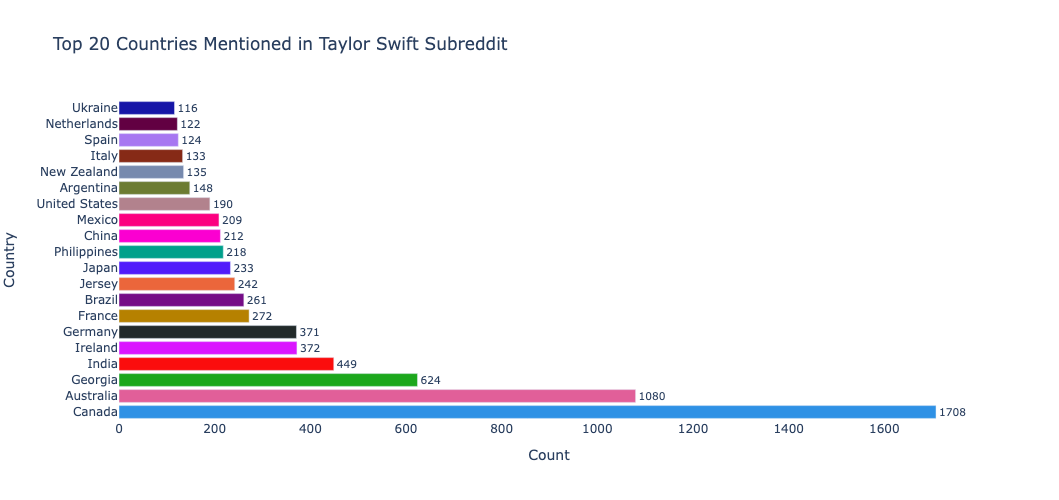

In [14]:
#import seaborn as sns
#import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
import kaleido


top_20 = Counter(submissions_countries+comments_countries).most_common(20)
country,count = zip(*top_20)
top_20_df = pd.DataFrame(data = {'country':list(country),'count':list(count)})

fig = go.Figure()
fig.add_trace(go.Bar(x = top_20_df['count'],y = top_20_df['country'],orientation = 'h',
                     text = top_20_df['count'],
                     textposition = 'outside',
                     marker = dict(color = px.colors.qualitative.Dark24)
            ))

fig.update_layout(
    title = 'Top 20 Countries Mentioned in Taylor Swift Subreddit',
    xaxis_title = 'Count',
    yaxis_title = 'Country',
    plot_bgcolor = 'white',
    #width = 800,
    height = 500)

#pio.write_image(fig,"country_analysis_bar_plot.png")
fig.write_image("country_analysis_bar_plot.svg")

fig.show()



### What about the language used in Taylor Swift subreddit?

In [36]:
# reduce the row numbers for computing and visualization, keep about 10000 records for each dataset

taylor_submissions_sample = taylor_submissions.sample(withReplacement = False,fraction = 10000/taylor_submissions.count(),seed = 123)
taylor_comments_sample = taylor_comments.sample(withReplacement = False,fraction = 10000/taylor_comments.count(),seed = 456)


In [29]:
!pip install langdetect
!pip install python-iso639


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
  Obtaining dependency information for python-iso639 from https://files.pythonhosted.org/packages/b8/6d/5d1f7e5c1b0c58b700eb67dbb570f9381afc90bc0535686a89e90eac5dfb/python_iso639-2023.6.15-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.1/275.1 kB 3.9 MB/s eta 0:00:00ta 0:00:01

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [37]:
from langdetect import detect
from pyspark.sql.types import StringType
import pyspark.sql.functions as f

# make udf, take text as input, return the language detected, return None if unable to determine the language
def get_language(text):
    try:
        return detect(text)
    except:
        return None
    
get_language_udf = f.udf(get_language,StringType())

# apply the udf, get language, get text length and score for further analysis

taylor_submissions_sample = taylor_submissions_sample.withColumn('language',get_language_udf(taylor_submissions_sample['text']))\
.withColumn("text_length",f.length(taylor_submissions_sample.text))\
.select('language','text_length','score')


taylor_comments_sample = taylor_comments_sample.withColumn('language',get_language_udf(taylor_comments_sample['body']))\
.withColumn("text_length",f.length(taylor_comments_sample.body))\
.select('language','text_length','score')
    

In [38]:
taylor_submissions_sample.show(10)

+--------+-----------+-----+
|language|text_length|score|
+--------+-----------+-----+
|      en|        581|   43|
|      en|         76|    1|
|      en|        377|  100|
|      en|         81| 1233|
|      ca|         14|    1|
|      en|        357|   35|
|      en|         44|    1|
|      en|        417|   35|
|      en|        480|   23|
|      de|         72|   42|
+--------+-----------+-----+
only showing top 10 rows



In [44]:
# compute language frequency, average text length, and average score

submissions_sample_agg = taylor_submissions_sample.groupBy('language').agg(f.round(f.avg('text_length'),2).alias('Average Text Length'),f.round(f.avg('score'),2).alias('Average Score'),f.count(f.col('language')).alias('Count'))\
.orderBy(f.col('Count').desc()).dropna()

submissions_sample_agg.show(10)
submissions_sample_agg.cache()

+--------+-------------------+-------------+-----+
|language|Average Text Length|Average Score|Count|
+--------+-------------------+-------------+-----+
|      en|             371.07|       177.07| 9705|
|      de|              31.66|         69.0|   64|
|      no|              30.82|       260.95|   39|
|      it|              28.32|       190.68|   34|
|      da|              32.39|       105.13|   31|
|      nl|              29.74|       168.81|   31|
|      af|              27.68|         88.0|   28|
|      es|              76.05|       116.68|   22|
|      fr|              28.05|       143.14|   21|
|      cy|              23.35|       120.35|   20|
+--------+-------------------+-------------+-----+
only showing top 10 rows



DataFrame[language: string, Average Text Length: double, Average Score: double, Count: bigint]

In [46]:
comments_sample_agg = taylor_comments_sample.groupBy('language').agg(f.round(f.avg('text_length'),2).alias('Average Text Length'),f.round(f.avg('score'),2).alias('Average Score'),f.count(f.col('language')).alias('Count'))\
.orderBy(f.col('Count').desc()).dropna()

comments_sample_agg.show(10)
comments_sample_agg.cache()

+--------+-------------------+-------------+-----+
|language|Average Text Length|Average Score|Count|
+--------+-------------------+-------------+-----+
|      en|             177.73|        13.77| 9223|
|      so|               15.1|        11.44|   79|
|      af|              26.14|         9.62|   76|
|      fr|              18.02|         4.59|   61|
|      de|              17.27|        18.17|   59|
|      no|              21.04|        13.02|   49|
|      tl|               14.4|         5.35|   40|
|      nl|              23.44|         8.76|   34|
|      id|              12.44|         6.35|   34|
|      it|              26.71|         8.35|   34|
+--------+-------------------+-------------+-----+
only showing top 10 rows



DataFrame[language: string, Average Text Length: double, Average Score: double, Count: bigint]

We can see that English language dominates the subreddit, remove english and analysis on the remaining languages

In [48]:
submissions_sample_agg = submissions_sample_agg.filter(f.col('language') !='en')
comments_sample_agg = comments_sample_agg.filter(f.col('language') != 'en')

In [49]:
# convert iso-639 language code to language names
import iso639

def code_to_name(lang_code):
    try:
        lang_info = iso639.Language.from_part1(lang_code)
        return lang_info.name
    except:
        return None
    
code_to_name_udf = f.udf(code_to_name,StringType())

submissions_sample_agg = submissions_sample_agg.withColumn("lang_name",code_to_name_udf(f.col('language'))).drop('language')
comments_sample_agg = comments_sample_agg.withColumn("lang_name",code_to_name_udf(f.col('language'))).drop('language')

submissions_sample_agg.cache()
comments_sample_agg.cache()
submissions_sample_agg.show(10)

+-------------------+-------------+-----+---------+
|Average Text Length|Average Score|Count|lang_name|
+-------------------+-------------+-----+---------+
|               32.8|        91.53|   64|   German|
|              30.94|       230.98|   47|Norwegian|
|              26.97|       165.42|   33|  Italian|
|              35.68|       154.97|   31|   Danish|
|              30.24|       119.59|   29|Afrikaans|
|              30.08|       125.44|   25|    Dutch|
|               27.0|       147.14|   21|   French|
|              27.05|       129.89|   19|  Spanish|
|              28.44|       240.11|   18|  Swedish|
|              31.06|        61.06|   17|  Catalan|
+-------------------+-------------+-----+---------+
only showing top 10 rows



In [50]:
# pyspark df to pandas df for visualization
submissions_sample_agg_df = submissions_sample_agg.toPandas()
comments_sample_agg_df = comments_sample_agg.toPandas()

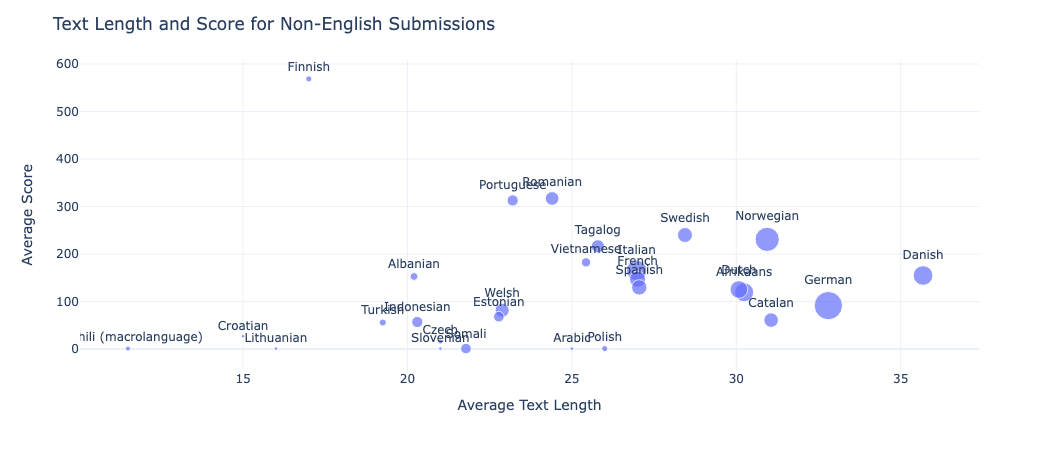

In [78]:
import plotly.express as px

fig = px.scatter(submissions_sample_agg_df,x = "Average Text Length",y = "Average Score",size = 'Count',text = "lang_name",template = "plotly_white")
fig.update_traces(textposition='top center')
fig.update_layout(
    height = 450,
    width = 1100,
    title_text='Text Length and Score for Non-English Submissions'
)

fig.write_image("language_analysis_submissions.svg")
fig.show()

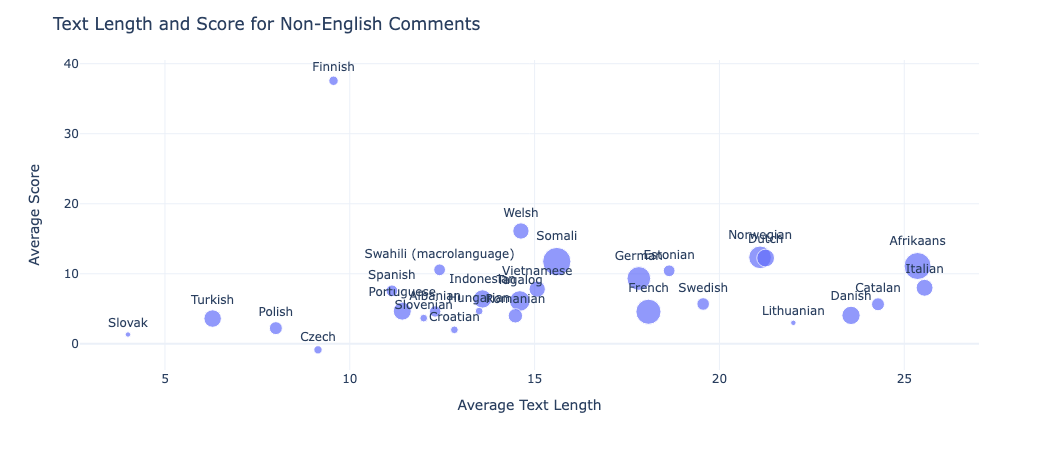

In [79]:
fig = px.scatter(comments_sample_agg_df,x = "Average Text Length",y = "Average Score",size = 'Count',text = "lang_name",template = "plotly_white")
fig.update_traces(textposition='top center')
fig.update_layout(
    height = 450,
    width = 1100,
    title_text='Text Length and Score for Non-English Comments'
)
fig.write_image("language_analysis_comments.svg")
fig.show()